In [33]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

Config finished!


In [34]:
in_names = ['X_train', 'X_val', 'y_train', 'y_val']
X_train, X_val, y_train, y_val = [pd.read_csv(f'./data/{name}.csv', index_col = 'Date', parse_dates=True) for name in in_names]

def reshape_input(X):
    return X.values.reshape(X.shape[0], X.shape[-1], 1)

X_train, X_val = [reshape_input(X) for X in [X_train, X_val]]

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X_val, y_val):
    y_val = y_val.reshape(y_val.shape[0], y_val.shape[1]) if len(y_val.shape) > 2 else y_val
    pred = model.predict(X_val)
    pred = pred.reshape(pred.shape[0], pred.shape[1]) if len(pred.shape) > 2 else pred

    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# SEED

In [37]:
from random import randint
seed_num = randint(0,10000)
# seed_num = 7548
from numpy.random import seed
seed(seed_num)
tf.random.set_seed(seed_num)
print('The seed is: ', seed_num)

The seed is:  8038


# Vanilla Simple RNN

In [38]:
# basic rnn
batch_size = 32
n_output = y_train.shape[-1]
n_timestep = X_train.shape[1]
n_features = 1
input_shape = (n_timestep, n_features)

model = keras.Sequential(
    [
        layers.SimpleRNN(200, activation='relu', input_shape= input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_output),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 200)               40400     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 61,005
Trainable params: 61,005
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train, y_train, batch_size = batch_size)

Train on 1719 samples
1719/1719 [==============================] - 3s 2ms/sample - loss: 1732.2764


In [40]:
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Result - MSE:  359.2128780445586  - MAPE:  0.21603347115082663
Result - MSE:  529.9260161329164  - MAPE:  2.4277646836982596


In [41]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

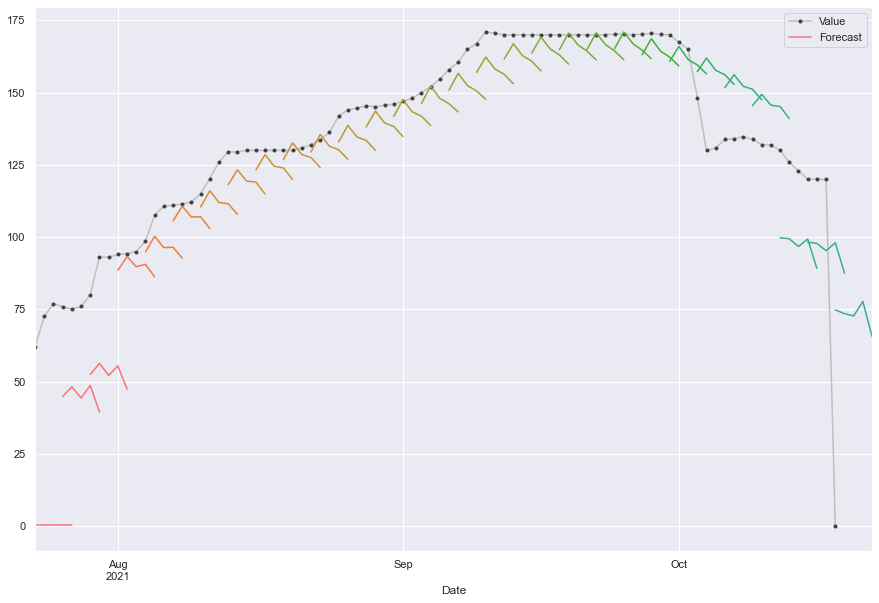

In [42]:
def plot_stepped_predictions(model, X_val, y_val, prediction_step = 3):
    pred = pd.DataFrame(
        model.predict(X_val),
        index = y_val.index, columns = y_val.columns
    )
    palette = dict(palette='husl', n_colors=64)
    ax2 = y_val['y_step_1'].plot(**plot_params)
    ax2 = plot_multistep(pred, ax=ax2, palette_kwargs=palette, every=prediction_step)
    _ = ax2.legend(['Value', 'Forecast'])

    plt.show()

plot_stepped_predictions(model, X_val, y_val, prediction_step = 3)

# Vanilla LSTM

In [43]:
model = keras.Sequential(
    [
        layers.LSTM(200, activation='relu', input_shape= input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_output),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 505       
Total params: 182,205
Trainable params: 182,205
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train, y_train, batch_size = batch_size)
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Train on 1719 samples
1719/1719 [==============================] - 3s 2ms/sample - loss: 986.6491
Result - MSE:  213.7272108840553  - MAPE:  0.5609432917272069
Result - MSE:  494.9706530364534  - MAPE:  10.608474134082993


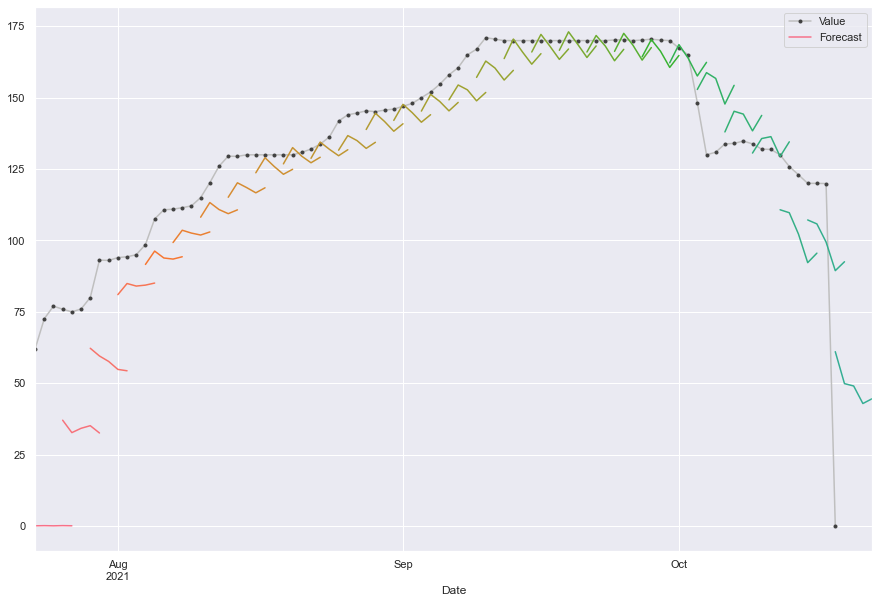

In [45]:
plot_stepped_predictions(model, X_val, y_val)

# EncDec LSTM

In [46]:
# basic rnn
model = keras.Sequential(
    [
        layers.LSTM(200, activation='relu', input_shape=input_shape),
        layers.RepeatVector(n_output),
        layers.LSTM(200, activation='relu', return_sequences=True),
        layers.TimeDistributed(layers.Dense(100, activation='relu')),
        layers.TimeDistributed(layers.Dense(1)),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 200)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


In [47]:
special_y_train = reshape_input(y_train)
special_y_val = reshape_input(y_val)

In [48]:
model.fit(X_train, special_y_train, batch_size = batch_size)
evaluate(model, X_train, special_y_train)
evaluate(model, X_val, special_y_val)

Train on 1719 samples
1719/1719 [==============================] - 7s 4ms/sample - loss: 1306.9663
Result - MSE:  228.11433497453305  - MAPE:  0.28687530074436046
Result - MSE:  482.67959381479307  - MAPE:  4.495519447918776


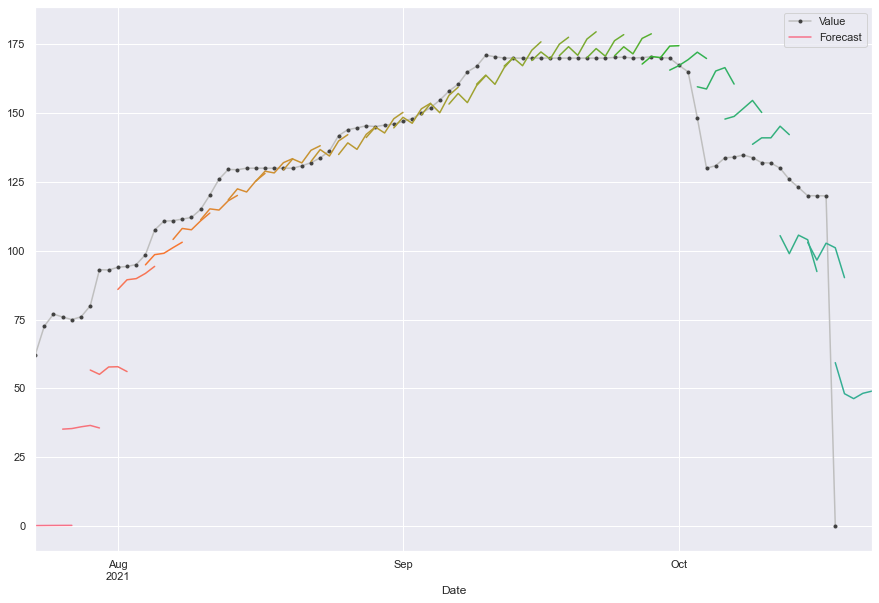

In [49]:
pred = model.predict(X_val)
pred = pred.reshape(pred.shape[0], pred.shape[1])
pred = pd.DataFrame(
    pred,
    index = y_val.index, columns = y_val.columns
)
palette = dict(palette='husl', n_colors=64)
ax2 = y_val['y_step_1'].plot(**plot_params)
ax2 = plot_multistep(pred, ax=ax2, palette_kwargs=palette, every=3)
_ = ax2.legend(['Value', 'Forecast'])

plt.show()

# Stacked 
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

In [56]:
model = keras.Sequential(
    [
        layers.LSTM(100, return_sequences=True, input_shape=input_shape),
        layers.Dropout(rate=0.2),
        layers.LSTM(100, return_sequences=True),
        layers.LSTM(100, return_sequences=False),
        layers.Dropout(rate=0.2),
        layers.Dense(n_output)
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 16, 100)           40800     
_________________________________________________________________
lstm_19 (LSTM)               (None, 16, 100)           80400     
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 505       
Total params: 202,105
Trainable params: 202,105
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(X_train, y_train, batch_size = batch_size)
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Train on 1719 samples
1719/1719 [==============================] - 8s 5ms/sample - loss: 12813.7976 6s - loss: 13
Result - MSE:  11943.943755888391  - MAPE:  9.545394761277619
Result - MSE:  16325.39090482425  - MAPE:  11.616323528152549


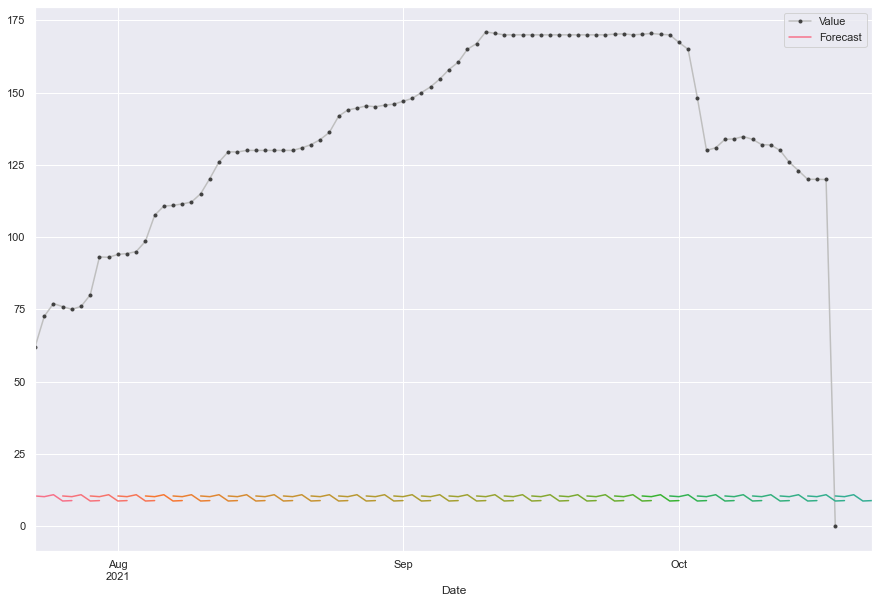

In [55]:
plot_stepped_predictions(model, X_val, y_val)

# Conclusion:
- Not great
- Cant capture anything
- Training result varies much on different training means that data is difficult and have many variance and stuffs
- Or maybe these models are not suitable